In [48]:
!pip install pytorch_pretrained_bert pytorch-nlp

In [ ]:
!pip install -qq transformers

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import transformers
import numpy as np
import torch

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from torch import nn, optim
from pylab import rcParams
from matplotlib import rc
from textwrap import wrap

# Config
Setting plot settings and constance


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
COLORS = ["#008cff", "#ffc800", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))
rcParams['figure.figsize'] = 12, 8

MAX_LEN = 512
BATCH_SIZE = 8
RANDOM_SEED = 17
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Data loading


In [52]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = '/content/gdrive/My Drive/data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# pd.set_option('display.max_columns', None)
df = pd.read_csv(PATH + 'news.csv')

In [ ]:
df = df.drop_duplicates(subset='text', keep="first")

In [ ]:
df['label'] = df['label'].map({'FAKE': 1, 'REAL': 0})

In [ ]:
df = df[['text', 'label']]

In [57]:
df.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,U.S. Secretary of State John F. Kerry said Mon...,0
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,It's primary day in New York and front-runners...,0


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6060 entries, 0 to 6334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6060 non-null   object
 1   label   6060 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.0+ KB


Let's look at label balance in out data


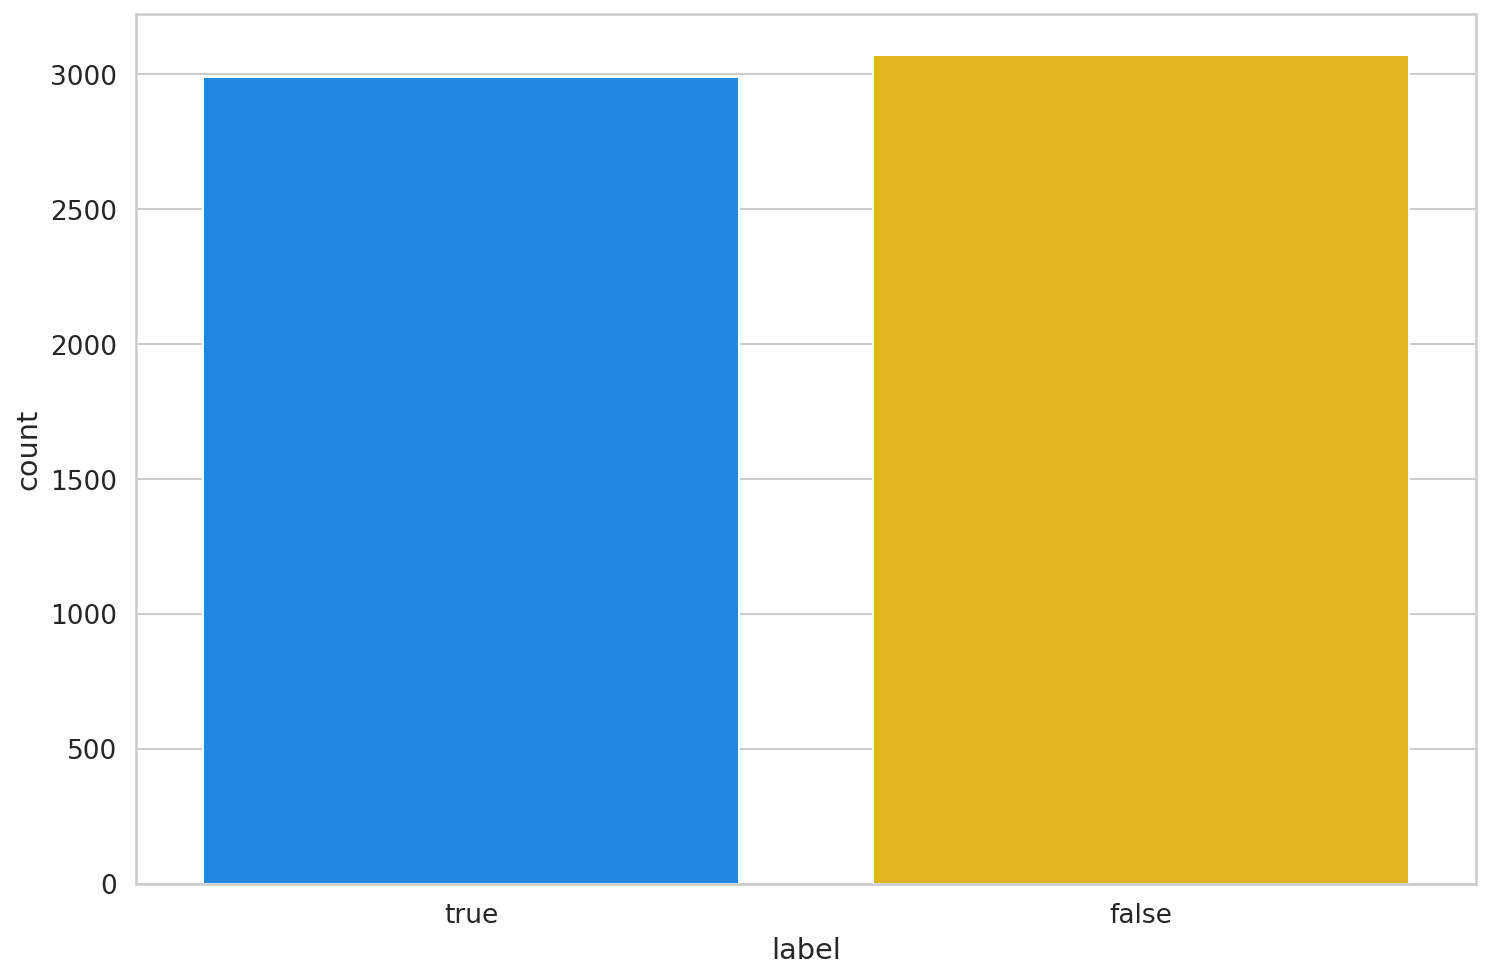

In [59]:
label_names = ['true', 'false']
ax = sns.countplot(df.label)
plt.xlabel
('labels balance')
ax.set_xticklabels(label_names);

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.
Let's use pre-trained BERT by huggingface team.

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
tokens_len = []
for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512)
    tokens_len.append(len(tokens))

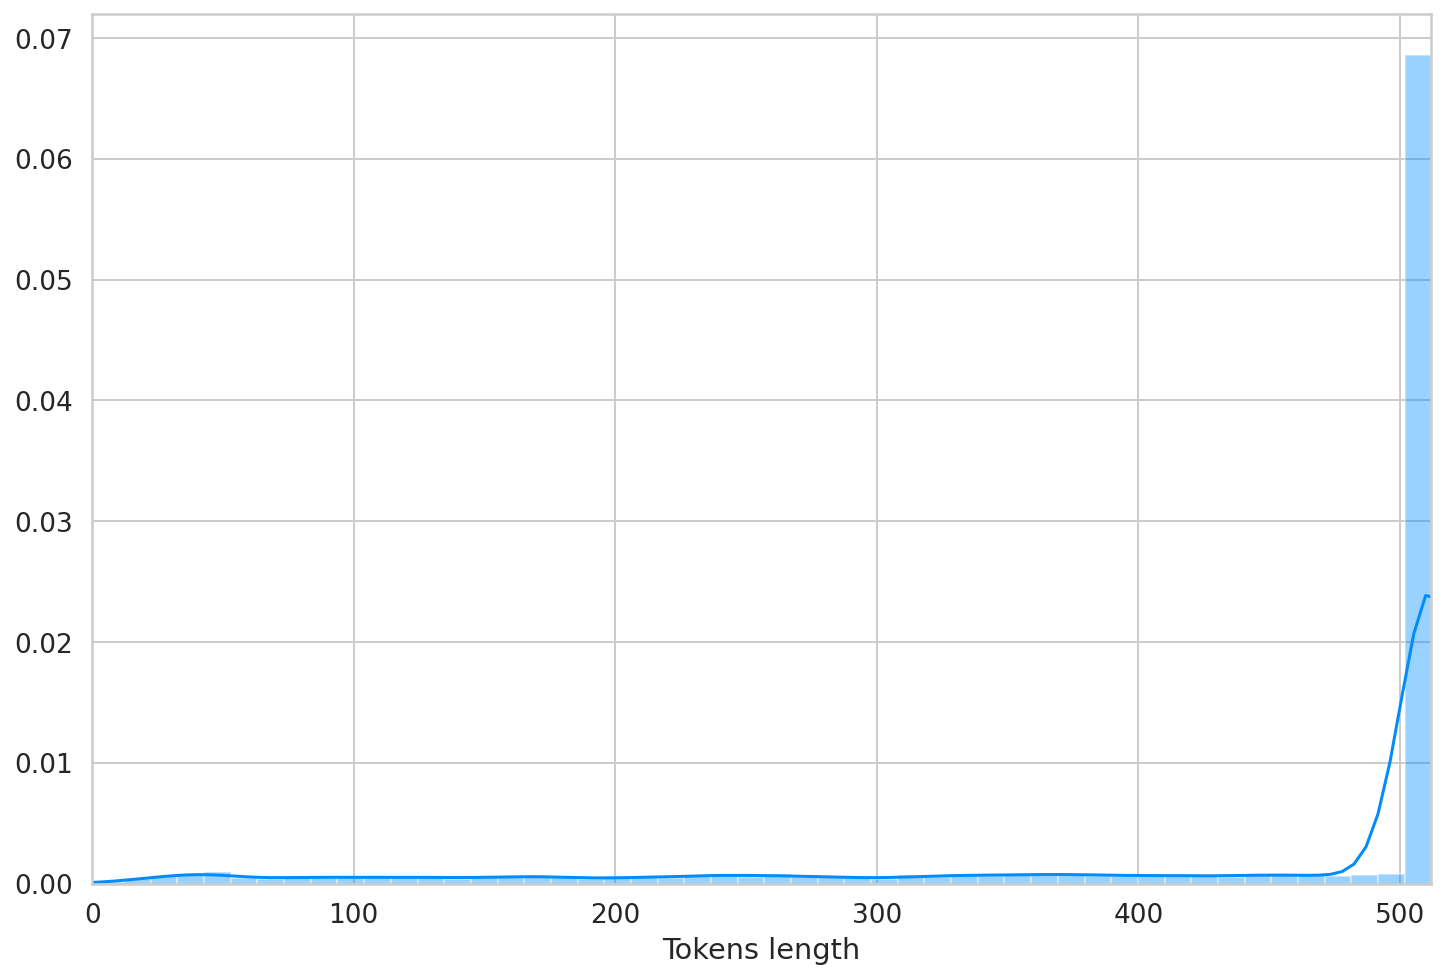

In [96]:
sns.distplot(tokens_len)
plt.xlim([0, 512]);
plt.xlabel('Tokens length');

Bert has a max length limit of tokens = 512, so in our case we will be used this limit and set max length to first 512 tokens. 

# Bert special tokens

We are required to:

*   Add special tokens to the start and end of each sentence.
*   Pad & truncate all sentences to a single constant length.
*   Explicitly differentiate real tokens from padding tokens with the "attention mask".

**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output.

![BERT_CLS_tokens](img/BERT_CLS.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))



Splitting a dataset to train, test, and validation

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [67]:
df_train.shape, df_val.shape, df_test.shape

((5454, 2), (303, 2), (303, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
    text = df.text.to_numpy(),
    label = df.label.to_numpy(),
    tokenizer = tokenizer,
    max_len = max_len
  )
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [71]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'label'])

In [72]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


# LabelClassifier

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class LabelClassifier(nn.Module):
    def __init__(self, n_classes):
    super(LabelClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = LabelClassifier(len(label_names))
model = model.to(device)

In [76]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([8, 512])
torch.Size([8, 512])


# Helper functions and model training loop

In [ ]:
EPOCHS = 20
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        label = d["label"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
    )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, label)
        correct_predictions += torch.sum(preds == label)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        label = d["label"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
      )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, label)
    correct_predictions += torch.sum(preds == label)
    losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [80]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
  )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/20
----------
Train loss 0.2665837249488848 accuracy 0.9248258159149249
Val   loss 0.4744124992897636 accuracy 0.9042904290429044

Epoch 2/20
----------
Train loss 0.10109099091550088 accuracy 0.9767143381004767
Val   loss 0.08992863009533673 accuracy 0.9867986798679869

Epoch 3/20
----------
Train loss 0.04468385483396613 accuracy 0.9913824715804914
Val   loss 0.09966167886006205 accuracy 0.9834983498349835

Epoch 4/20
----------
Train loss 0.018226496780602636 accuracy 0.9970663733039971
Val   loss 0.15259238550980195 accuracy 0.976897689768977

Epoch 5/20
----------
Train loss 0.010498441056596919 accuracy 0.9983498349834984
Val   loss 0.17021404520461433 accuracy 0.976897689768977

Epoch 6/20
----------
Train loss 0.013700758155256443 accuracy 0.9974330766409975
Val   loss 0.15308381202526347 accuracy 0.9801980198019802

Epoch 7/20
----------
Train loss 0.0018182351970396542 accuracy 0.9996332966629996
Val   loss 0.21132372118028653 accuracy 0.976897689768977

Epoch 8/20
--

Plotting the training vs validation accuracy

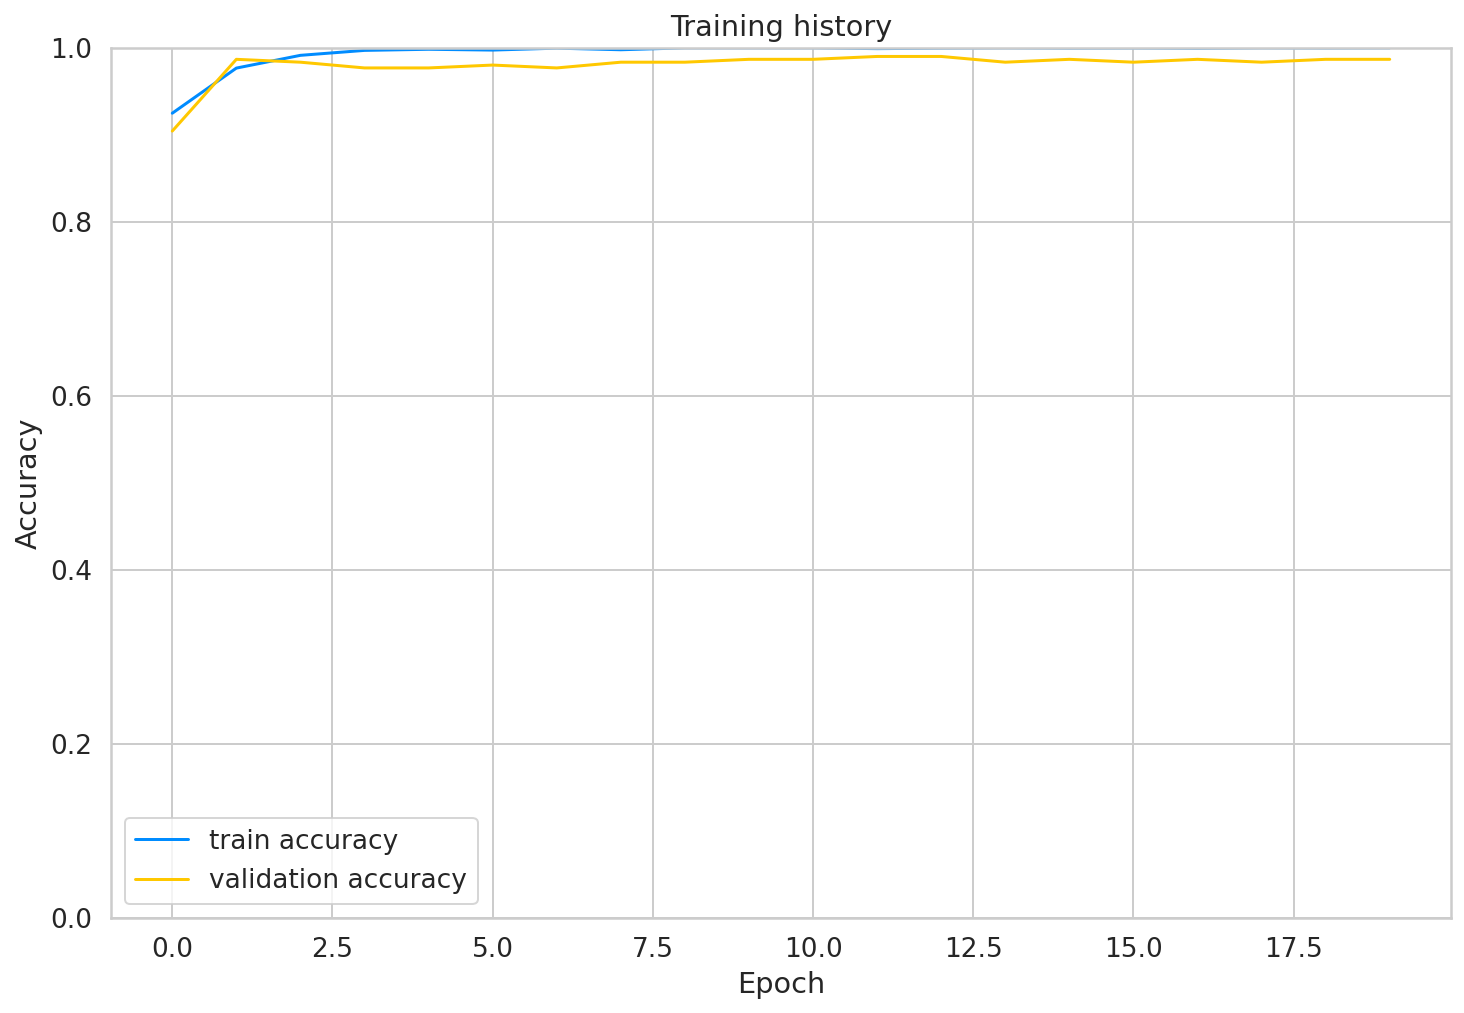

In [93]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Let's view the summary of the training process

In [ ]:
model = LabelClassifier(len(label_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Calculating the accuracy on the test data:

In [88]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.9867986798679869

Defining a helper function to get the predictions from our model

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    art_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
    for d in data_loader:
        texts = d["text"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        label = d["label"].to(device)
        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
        _, preds = torch.max(outputs, dim=1)
        art_texts.extend(texts)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        real_values.extend(label)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return art_texts, predictions, prediction_probs, real_values

In [ ]:
y_art_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Classification report and confusion matrix

In [91]:
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

        true       0.98      1.00      0.99       157
       false       1.00      0.97      0.99       146

    accuracy                           0.99       303
   macro avg       0.99      0.99      0.99       303
weighted avg       0.99      0.99      0.99       303



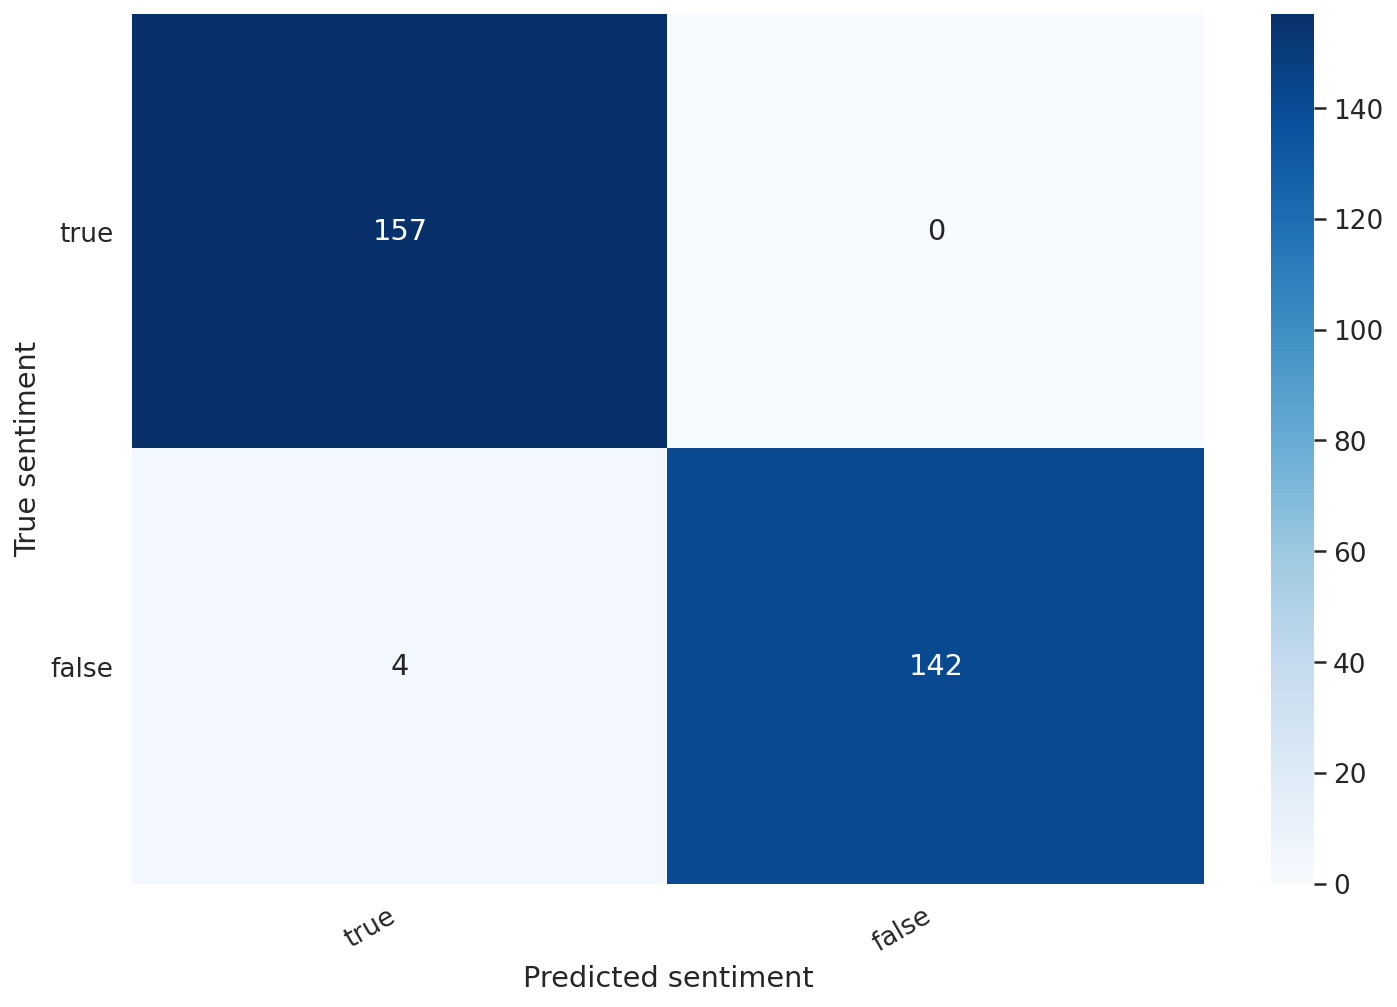

In [92]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=label_names, columns=label_names)
show_confusion_matrix(df_cm)

Best results achieved with a pre-trained BERT model, it's look good with cutting articles by BERT max tokens length (we can trying to cut not only first tokens, and some different techniks).
But like a conclusion: our basic models can get good results on this task, so if we don't need the maximum accuracy we can easely use something like logistic regression or naive bayes classifier.